In [21]:
%load_ext autoreload
%autoreload 2

import os
import warnings

from IPython.core.debugger import set_trace
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, HTML, Javascript
from tqdm import tqdm


def alert(message='Loop completed!'):
    # Check if the system supports 'say' and notifications
    os.system(f'osascript -e \'display notification "{message}" with title "Notification"\'')
    # Speak the alert
    os.system(f'say "{message}"')        
        
os.environ['PYTHONBREAKPOINT'] = 'IPython.core.debugger.set_trace'
breakpoint = set_trace
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import pandas as pd
import textstat
from sklearn.preprocessing import MinMaxScaler

In [53]:
measures_df = pd.read_csv('data/archive/measures_20250305.csv')
ballot_data_df = pd.read_csv('data/archive/data_20241119.csv')
state_measures_df = pd.read_csv('data/archive/state_measures_20250412.csv')
precinct_df = pd.read_csv('data/archive/precincts-with-results.csv')

state_measures_df['level'] = 'state-level'
state_measures_df['measure_name'] = state_measures_df.title + ':'
state_measures_df['no_vote'] = state_measures_df.no_vote_meaning
state_measures_df['yes_vote'] = state_measures_df.yes_vote_meaning

measures_df = pd.concat([measures_df, state_measures_df], ignore_index=True)

# Create mapping of measure titles to ballot text
measure_text_map = dict(zip(measures_df.title, measures_df.ballot_text))

Now let's extract the ballot content and compute initial readability scores:

In [54]:
# Extract ballot content from full markdown
ballot_data_df['ballot_text'] = ballot_data_df.full_markdown.apply(lambda x: x.partition('\n---\n')[-1])

# Calculate initial readability scores
ballot_data_df['dale_chall_initial'] = ballot_data_df.ballot_text.progress_apply(textstat.dale_chall_readability_score_v2)
ballot_data_df['flesch_kincaid_initial'] = ballot_data_df.ballot_text.progress_apply(textstat.flesch_kincaid_grade)

# Calculate percentile rankings for readability scores
ballot_data_df['flesch_kincaid_percentile_initial'] = ballot_data_df.flesch_kincaid_initial.rank(pct=True)
ballot_data_df['dale_chall_percentile_initial'] = ballot_data_df.dale_chall_initial.rank(pct=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 50579/50579 [00:11<00:00, 4356.37it/s]


Extract measure titles from markdown:

In [55]:
def extract_ballot_measures(markdown_text):
    """Extract ballot measure titles from markdown text."""
    measures = []
    for section in markdown_text.split('---'):
        if '**Type:** Ballot Measure' in section:
            measure_title = section.split('## ')[1].split('\n')[0]
            measures.append(measure_title)
    return measures

# Extract measure titles from markdown
ballot_data_df['measure_titles'] = ballot_data_df.full_markdown.apply(extract_ballot_measures)

# Extract measure texts for each ballot
ballot_data_df['measure_texts'] = ballot_data_df.measure_titles.apply(
    lambda titles: [measure_text_map.get(title) for title in titles if title in measure_text_map]
)

Create enhanced ballots with measure texts and compute updated readability scores:

In [56]:
def create_enhanced_ballot(row):
    """Create enhanced ballot by inserting measure texts."""
    enhanced_text = row.ballot_text
    for measure_title in row.measure_titles:
        if measure_title in measure_text_map:
            enhanced_text = enhanced_text.replace(
                measure_title, 
                f'{measure_title}\n\n{measure_text_map[measure_title]}'
            )
    return enhanced_text

# Create enhanced ballots
ballot_data_df['enhanced_ballot'] = ballot_data_df.apply(create_enhanced_ballot, axis=1)

# Calculate updated readability scores
ballot_data_df['dale_chall_enhanced'] = ballot_data_df.enhanced_ballot.progress_apply(textstat.dale_chall_readability_score_v2)
ballot_data_df['flesch_kincaid_enhanced'] = ballot_data_df.enhanced_ballot.progress_apply(textstat.flesch_kincaid_grade)

# Calculate percentile rankings for updated scores
ballot_data_df['flesch_kincaid_percentile_enhanced'] = ballot_data_df.flesch_kincaid_enhanced.rank(pct=True)
ballot_data_df['dale_chall_percentile_enhanced'] = ballot_data_df.dale_chall_enhanced.rank(pct=True)

# Calculate changes in complexity
ballot_data_df['dale_chall_flesch_diff'] = ballot_data_df.dale_chall_percentile_enhanced - ballot_data_df.flesch_kincaid_percentile_enhanced
ballot_data_df['flesch_kincaid_change'] = ballot_data_df.flesch_kincaid_percentile_enhanced - ballot_data_df.flesch_kincaid_percentile_initial
ballot_data_df['dale_chall_change'] = ballot_data_df.dale_chall_percentile_enhanced - ballot_data_df.dale_chall_percentile_initial

100%|██████████████████████████████████████████████████████████████████████████████████| 50579/50579 [00:14<00:00, 3526.47it/s]


Analyze differences in text complexity:

In [57]:
import difflib

def generate_text_diff(text1, text2, context_lines=2):
    """Generate a unified diff between two texts."""
    diff = difflib.unified_diff(
        text1.splitlines(), text2.splitlines(), lineterm='', n=context_lines
    )
    return '\n'.join(diff)

# Function to display complexity changes
def display_complexity_changes(sorted_df, metric_name, n=5):
    """Display ballots with largest increases and decreases in complexity."""
    print(f'===== {metric_name.replace("_", " ").title()} =====')
    
    print('\nBIGGEST INCREASES IN COMPLEXITY:')
    increases = sorted_df.head(n)
    print(increases.drop(columns=['ballot_text', 'enhanced_ballot']).head())
    
    for i, row in increases.head(3).iterrows():
        print('\n------- Text Diff -------')
        diff = generate_text_diff(row.ballot_text, row.enhanced_ballot)
        print(diff)
    
    print('\nBIGGEST DECREASES IN COMPLEXITY:')
    decreases = sorted_df.tail(n)
    print(decreases.drop(columns=['ballot_text', 'enhanced_ballot']).tail())
    
    for i, row in decreases.tail(3).iterrows():
        print('\n------- Text Diff -------')
        diff = generate_text_diff(row.ballot_text, row.enhanced_ballot)
        print(diff)

# Create sorted dataframes
dale_chall_diff_df = ballot_data_df.sort_values(by='dale_chall_flesch_diff')[
    ['state', 'district', 'county', 'zip', 'ballot_text', 'enhanced_ballot', 
     'dale_chall_flesch_diff', 'dale_chall_percentile_enhanced', 'flesch_kincaid_percentile_enhanced']
]

flesch_kincaid_change_df = ballot_data_df.sort_values(by='flesch_kincaid_change')[
    ['state', 'district', 'county', 'zip', 'ballot_text', 'enhanced_ballot', 
     'flesch_kincaid_change', 'flesch_kincaid_percentile_initial', 'flesch_kincaid_percentile_enhanced']
]

dale_chall_change_df = ballot_data_df.sort_values(by='dale_chall_change')[
    ['state', 'district', 'county', 'zip', 'ballot_text', 'enhanced_ballot', 
     'dale_chall_change', 'dale_chall_percentile_initial', 'dale_chall_percentile_enhanced', 
     'dale_chall_enhanced', 'dale_chall_initial']
]

# Display complexity changes
pd.set_option('max_colwidth', 250)
display_complexity_changes(dale_chall_diff_df, 'dale_chall_flesch_diff')
display_complexity_changes(flesch_kincaid_change_df, 'flesch_kincaid_change')
display_complexity_changes(dale_chall_change_df, 'dale_chall_change')

# Check correlation between readability metrics
print('\nDALE CHALL vs. FLESCH-KINCAID CORRELATION:')
correlation, p_value = pearsonr(ballot_data_df.dale_chall_percentile_enhanced, 
                                ballot_data_df.flesch_kincaid_percentile_enhanced)
print(f"Correlation: {correlation:.4f}, p-value: {p_value:.4f}")

===== Dale Chall Flesch Diff =====

BIGGEST INCREASES IN COMPLEXITY:
        state district   county    zip  dale_chall_flesch_diff  \
8983  Georgia  GA-CD09  Jackson  30543                -0.90246   
8982  Georgia  GA-CD09  Jackson  30530                -0.90246   
8984  Georgia  GA-CD09  Jackson  30548                -0.89898   
8995  Georgia  GA-CD09  Jackson  30680                -0.89898   
8969  Georgia  GA-CD09     Hall  30517                -0.89898   

      dale_chall_percentile_enhanced  flesch_kincaid_percentile_enhanced  
8983                        0.048449                            0.950908  
8982                        0.048449                            0.950908  
8984                        0.047312                            0.946292  
8995                        0.047312                            0.946292  
8969                        0.047312                            0.946292  

------- Text Diff -------
--- 
+++ 
@@ -543,4 +543,6 @@
 ## Georgia Amendment 1, Lo

NameError: name 'pearsonr' is not defined

Prepare measure data for analysis:

In [67]:
# Clean and prepare measure data
measure_analysis_df = measures_df.dropna(subset=['title', 'ballot_text', 'yes_votes', 'no_votes']).copy()

# Calculate readability scores for measures
measure_analysis_df['dale_chall_score'] = measure_analysis_df.ballot_text.apply(textstat.dale_chall_readability_score_v2)
measure_analysis_df['flesch_kincaid_score'] = measure_analysis_df.ballot_text.apply(textstat.flesch_kincaid_grade)

# Clean vote count data
measure_analysis_df['yes_count'] = measure_analysis_df.yes_votes.apply(lambda x: int(x.replace(',', '')))
measure_analysis_df['no_count'] = measure_analysis_df.no_votes.apply(lambda x: int(x.replace(',', '')))
measure_analysis_df['vote_margin'] = measure_analysis_df.yes_count - measure_analysis_df.no_count
measure_analysis_df['total_votes'] = measure_analysis_df.yes_count + measure_analysis_df.no_count

# Extract locale from title
measure_analysis_df['locale'] = measure_analysis_df.title.apply(lambda x: x.split(', ')[0])

Analyze correlations between readability and voting patterns:

In [68]:
from scipy.stats import pearsonr
import numpy as np

# Group measures by state and locale to analyze local patterns
def calculate_correlation(df, x_col, y_col):
    """Calculate Pearson correlation if sufficient data points exist."""
    if len(df) > 1:
        return pearsonr(df[x_col], df[y_col])[0]
    return np.nan

# Calculate correlations at local level
print('\nAVERAGE CORRELATIONS BY LOCALE:')

print('\nYES VOTES vs. DALE-CHALL CORRELATION:')
yes_dc_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'yes_count', 'dale_chall_score')
).dropna().mean()
print(f"Average correlation: {yes_dc_corr:.4f}")

print('\nYES VOTES vs. FLESCH-KINCAID CORRELATION:')
yes_fk_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'yes_count', 'flesch_kincaid_score')
).dropna().mean()
print(f"Average correlation: {yes_fk_corr:.4f}")

print('\nTURNOUT vs. DALE-CHALL CORRELATION:')
turnout_dc_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'total_votes', 'dale_chall_score')
).dropna().mean()
print(f"Average correlation: {turnout_dc_corr:.4f}")

print('\nTURNOUT vs. FLESCH-KINCAID CORRELATION:')
turnout_fk_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'total_votes', 'flesch_kincaid_score')
).dropna().mean()
print(f"Average correlation: {turnout_fk_corr:.4f}")


AVERAGE CORRELATIONS BY LOCALE:

YES VOTES vs. DALE-CHALL CORRELATION:
Average correlation: 0.0400

YES VOTES vs. FLESCH-KINCAID CORRELATION:
Average correlation: 0.1303

TURNOUT vs. DALE-CHALL CORRELATION:
Average correlation: 0.1206

TURNOUT vs. FLESCH-KINCAID CORRELATION:
Average correlation: 0.0764


Scale metrics and analyze overall correlations:

In [124]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import numpy as np

# First filter the unrealistically high Flesch-Kincaid scores from measure_analysis_df
filtered_measure_df = measure_analysis_df[measure_analysis_df.flesch_kincaid_score <= 50]

# Normalize metrics within each locale for fair comparison
scaler = MinMaxScaler()

# Function to scale a column within each locale group
def scale_within_group(group):
    """Apply min-max scaling within a group if it has enough data points."""
    if len(group) > 1:
        return scaler.fit_transform(group.values.reshape(-1, 1)).flatten()
    return [np.nan] * len(group)

# Scale metrics within each locale using the filtered data
grouped = filtered_measure_df.groupby(['state', 'locale'])

filtered_measure_df['scaled_dale_chall'] = grouped.dale_chall_score.transform(
    lambda x: scale_within_group(x)
)
filtered_measure_df['scaled_flesch_kincaid'] = grouped.flesch_kincaid_score.transform(
    lambda x: scale_within_group(x)
)
filtered_measure_df['scaled_yes_count'] = grouped.yes_count.transform(
    lambda x: scale_within_group(x)
)
filtered_measure_df['scaled_vote_margin'] = grouped.vote_margin.transform(
    lambda x: scale_within_group(x)
)
filtered_measure_df['scaled_total_votes'] = grouped.total_votes.transform(
    lambda x: scale_within_group(x)
)

# Filter out rows with missing scaled values
filtered_scaled_df = filtered_measure_df.dropna(subset=[
    'scaled_dale_chall', 'scaled_flesch_kincaid', 
    'scaled_yes_count', 'scaled_total_votes', 'scaled_vote_margin'
])

# Calculate correlations across all measures with filtered data
print('\nOVERALL CORRELATIONS (SCALED METRICS, FILTERED DATA):')
print(f'Data points after filtering: {len(filtered_scaled_df)} (removed {len(scaled_analysis_df) - len(filtered_scaled_df)} points with FK > 50)')

print('\nDALE-CHALL vs. MARGIN OF VICTORY:')
dc_margin_corr, dc_margin_p = pearsonr(filtered_scaled_df.scaled_dale_chall, filtered_scaled_df.scaled_vote_margin)
print(f"Correlation: {dc_margin_corr:.4f}, p-value: {dc_margin_p:.4f}")

print('\nFLESCH-KINCAID vs. MARGIN OF VICTORY:')
fk_margin_corr, fk_margin_p = pearsonr(filtered_scaled_df.scaled_flesch_kincaid, filtered_scaled_df.scaled_vote_margin)
print(f"Correlation: {fk_margin_corr:.4f}, p-value: {fk_margin_p:.4f}")

print('\nDALE-CHALL vs. YES VOTES:')
dc_yes_corr, dc_yes_p = pearsonr(filtered_scaled_df.scaled_dale_chall, filtered_scaled_df.scaled_yes_count)
print(f"Correlation: {dc_yes_corr:.4f}, p-value: {dc_yes_p:.4f}")

print('\nFLESCH-KINCAID vs. YES VOTES:')
fk_yes_corr, fk_yes_p = pearsonr(filtered_scaled_df.scaled_flesch_kincaid, filtered_scaled_df.scaled_yes_count)
print(f"Correlation: {fk_yes_corr:.4f}, p-value: {fk_yes_p:.4f}")

print('\nDALE-CHALL vs. TURNOUT:')
dc_turnout_corr, dc_turnout_p = pearsonr(filtered_scaled_df.scaled_dale_chall, filtered_scaled_df.scaled_total_votes)
print(f"Correlation: {dc_turnout_corr:.4f}, p-value: {dc_turnout_p:.4f}")

print('\nFLESCH-KINCAID vs. TURNOUT:')
fk_turnout_corr, fk_turnout_p = pearsonr(filtered_scaled_df.scaled_flesch_kincaid, filtered_scaled_df.scaled_total_votes)
print(f"Correlation: {fk_turnout_corr:.4f}, p-value: {fk_turnout_p:.4f}")


OVERALL CORRELATIONS (SCALED METRICS, FILTERED DATA):
Data points after filtering: 673 (removed 18 points with FK > 50)

DALE-CHALL vs. MARGIN OF VICTORY:
Correlation: 0.0354, p-value: 0.3594

FLESCH-KINCAID vs. MARGIN OF VICTORY:
Correlation: 0.1365, p-value: 0.0004

DALE-CHALL vs. YES VOTES:
Correlation: 0.0514, p-value: 0.1833

FLESCH-KINCAID vs. YES VOTES:
Correlation: 0.1085, p-value: 0.0048

DALE-CHALL vs. TURNOUT:
Correlation: 0.1108, p-value: 0.0040

FLESCH-KINCAID vs. TURNOUT:
Correlation: 0.0680, p-value: 0.0781


Finally, create a visualization of the key relationship:

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='scaled_flesch_kincaid', ylabel='scaled_vote_margin'>

<Axes: xlabel='scaled_flesch_kincaid', ylabel='scaled_vote_margin'>

Text(0.5, 0, 'Flesch-Kincaid Grade Level (Filtered & Scaled)')

Text(0, 0.5, 'Vote Margin (Filtered & Scaled)')

Text(0.5, 1.0, 'Relationship Between Ballot Readability and Margin of Victory')

Text(0.05, 0.95, 'Correlation: 0.1365\np-value: 0.0004')

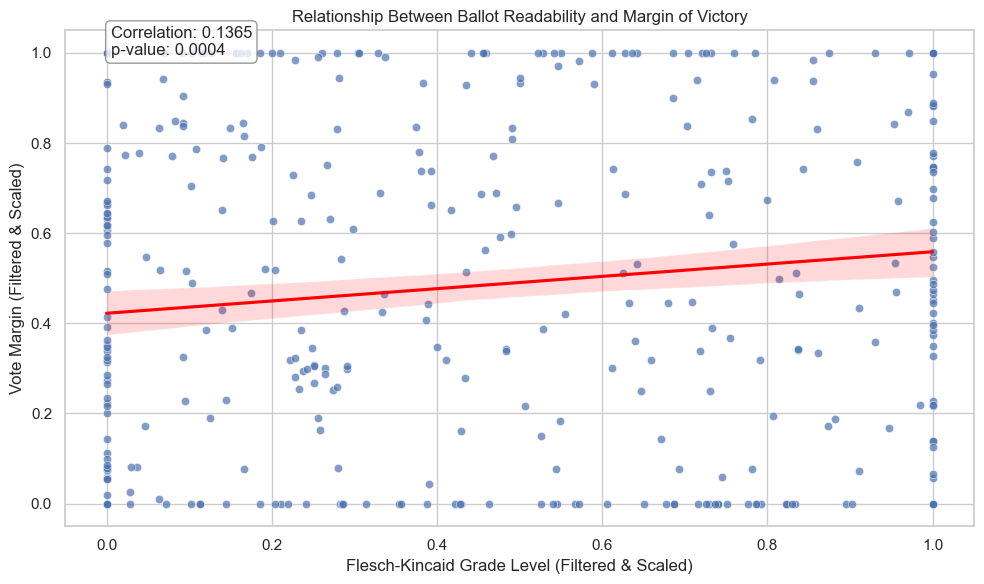

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create scatter plot with margin of victory instead of yes count
sns.scatterplot(
    data=filtered_scaled_df, 
    x='scaled_flesch_kincaid', 
    y='scaled_vote_margin',
    alpha=0.7
)

# Add regression line
sns.regplot(
    data=filtered_scaled_df, 
    x='scaled_flesch_kincaid', 
    y='scaled_vote_margin',
    scatter=False, 
    line_kws={"color": "red"}
)

# Add labels and title
plt.xlabel('Flesch-Kincaid Grade Level (Filtered & Scaled)')
plt.ylabel('Vote Margin (Filtered & Scaled)')
plt.title('Relationship Between Ballot Readability and Margin of Victory')

# Add correlation information
plt.annotate(
    f'Correlation: {fk_margin_corr:.4f}\np-value: {fk_margin_p:.4f}',
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

plt.tight_layout()
plt.show()

In [112]:
import pandas as pd
from pingouin import partial_corr
import wquantiles

# Apply weighted correlations with p-values
print('\nTURNOUT-WEIGHTED CORRELATIONS (using pingouin):')

# Filter to only include complete data
complete_data = measure_analysis_df.dropna(subset=['dale_chall_score', 'flesch_kincaid_score', 
                                                  'yes_count', 'vote_margin', 'total_votes'])

# Create a DataFrame with the variables of interest
corr_data = pd.DataFrame({
    'dale_chall': complete_data.dale_chall_score,
    'flesch_kincaid': complete_data.flesch_kincaid_score,
    'yes_votes': complete_data.yes_count,
    'vote_margin': complete_data.vote_margin,
    'weights': complete_data.total_votes
})

# Calculate weighted correlations with p-values using pingouin's partial_corr
# with the weights as a covariate (this effectively creates a weighted correlation)
print('\nWeighted DALE-CHALL vs. YES VOTES:')
dc_yes_result = partial_corr(data=corr_data, x='dale_chall', y='yes_votes', 
                            covar='weights', method='pearson')
print(f"Weighted correlation: {dc_yes_result['r'].values[0]:.16f}, p-value: {dc_yes_result['p-val'].values[0]:.16f}")

print('\nWeighted FLESCH-KINCAID vs. YES VOTES:')
fk_yes_result = partial_corr(data=corr_data, x='flesch_kincaid', y='yes_votes', 
                            covar='weights', method='pearson')
print(f"Weighted correlation: {fk_yes_result['r'].values[0]:.16f}, p-value: {fk_yes_result['p-val'].values[0]:.16f}")

print('\nWeighted DALE-CHALL vs. VOTE MARGIN:')
dc_margin_result = partial_corr(data=corr_data, x='dale_chall', y='vote_margin', 
                               covar='weights', method='pearson')
print(f"Weighted correlation: {dc_margin_result['r'].values[0]:.16f}, p-value: {dc_margin_result['p-val'].values[0]:.16f}")

print('\nWeighted FLESCH-KINCAID vs. VOTE MARGIN:')
fk_margin_result = partial_corr(data=corr_data, x='flesch_kincaid', y='vote_margin', 
                               covar='weights', method='pearson')
print(f"Weighted correlation: {fk_margin_result['r'].values[0]:.16f}, p-value: {fk_margin_result['p-val'].values[0]:.16f}")


TURNOUT-WEIGHTED CORRELATIONS (using pingouin):

Weighted DALE-CHALL vs. YES VOTES:
Weighted correlation: -0.0546005363036410, p-value: 0.0358889621563793

Weighted FLESCH-KINCAID vs. YES VOTES:
Weighted correlation: 0.0027613206449432, p-value: 0.9155563594585071

Weighted DALE-CHALL vs. VOTE MARGIN:
Weighted correlation: -0.0546005363036417, p-value: 0.0358889621563767

Weighted FLESCH-KINCAID vs. VOTE MARGIN:
Weighted correlation: 0.0027613206449434, p-value: 0.9155563594585006


Text(0.5, 0, 'Flesch-Kincaid Grade Level')

Text(0, 0.5, 'Vote Margin (% of Total Votes)')

Text(0.5, 1.0, 'Ballot Readability vs. Vote Margin\nColored by Voter Turnout (log scale)')

Text(-4.48, 0.5, 'Passed')

Text(-4.48, -0.5, 'Failed')

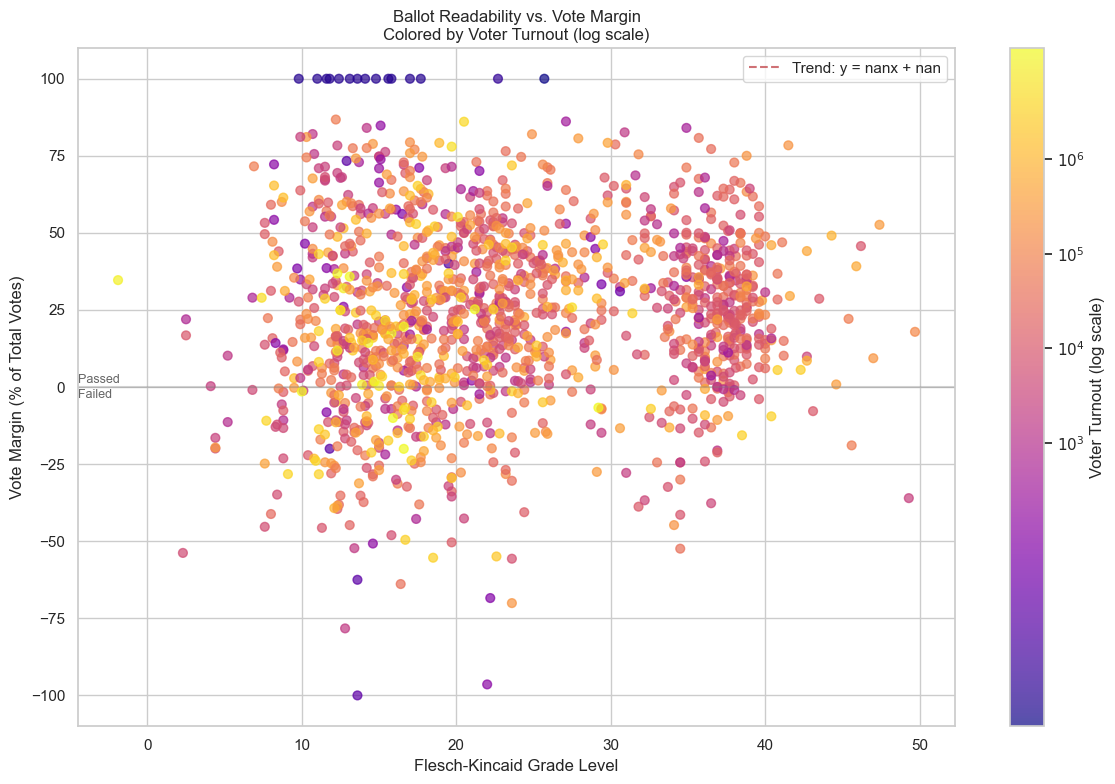

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting theme
sns.set_theme(style="whitegrid")

# Data cleaning - filter out unrealistic grade levels above 50
filtered_data = complete_data[complete_data.flesch_kincaid_score <= 50]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Use a more distinct colormap
turnout_cmap = plt.cm.plasma

# Get log10 of turnout for coloring
log_turnout = np.log10(filtered_data.total_votes)

# Create scatter plot with smaller dots
scatter = ax.scatter(
    filtered_data.flesch_kincaid_score,
    filtered_data.vote_margin / filtered_data.total_votes * 100,  # Convert to percentage
    s=40,  # Smaller size for all points
    c=log_turnout,  # Log-scaled turnout for coloring
    cmap=turnout_cmap,
    alpha=0.7
)

# Add a trend line based on the filtered data
z = np.polyfit(filtered_data.flesch_kincaid_score, 
               filtered_data.vote_margin / filtered_data.total_votes * 100, 1)
p = np.poly1d(z)
ax.plot(
    sorted(filtered_data.flesch_kincaid_score),
    p(sorted(filtered_data.flesch_kincaid_score)),
    "r--", 
    alpha=0.8,
    label=f"Trend: y = {z[0]:.2f}x + {z[1]:.2f}"
)

# Add a colorbar with manually specified log ticks
cbar = fig.colorbar(scatter, ax=ax)

# Manually set log ticks at reasonable intervals
log_ticks = [3, 4, 5, 6]  # Representing 10^3, 10^4, 10^5, 10^6

# Format the colorbar ticks with exponential notation
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([f'$10^{x}$' for x in log_ticks])
cbar.set_label('Voter Turnout (log scale)')

# Add labels and title
ax.set_xlabel('Flesch-Kincaid Grade Level')
ax.set_ylabel('Vote Margin (% of Total Votes)')
ax.set_title('Ballot Readability vs. Vote Margin\nColored by Voter Turnout (log scale)')

# Add a legend
ax.legend(loc='best')

# Add a horizontal line at y=0 to show the pass/fail threshold
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.text(ax.get_xlim()[0], 0.5, 'Passed', fontsize=9, va='bottom', alpha=0.7)
ax.text(ax.get_xlim()[0], -0.5, 'Failed', fontsize=9, va='top', alpha=0.7)

plt.tight_layout()
plt.savefig('readability_vs_vote_margin_turnout_color_filtered.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

Text(0.5, 0.98, 'Distribution of Readability Scores by Vote Outcome')

<Axes: xlabel='dale_chall_score', ylabel='Count'>

Text(0.5, 1.0, 'Dale-Chall Score Distribution')

Text(0.5, 0, 'Dale-Chall Readability Score')

Text(0, 0.5, 'Count')

<Axes: xlabel='flesch_kincaid_score', ylabel='Count'>

Text(0.5, 1.0, 'Flesch-Kincaid Grade Level Distribution')

Text(0.5, 0, 'Flesch-Kincaid Grade Level')

Text(0, 0.5, 'Count')

<Axes: xlabel='dale_chall_score', ylabel='None'>

Text(0.5, 1.0, 'Dale-Chall Score vs. Yes Vote Percentage')

Text(0.5, 0, 'Dale-Chall Readability Score')

Text(0, 0.5, 'Yes Vote Percentage')

<Axes: xlabel='flesch_kincaid_score', ylabel='None'>

Text(0.5, 1.0, 'Flesch-Kincaid Grade Level vs. Yes Vote Percentage')

Text(0.5, 0, 'Flesch-Kincaid Grade Level')

Text(0, 0.5, 'Yes Vote Percentage')

<Figure size 1400x1000 with 0 Axes>

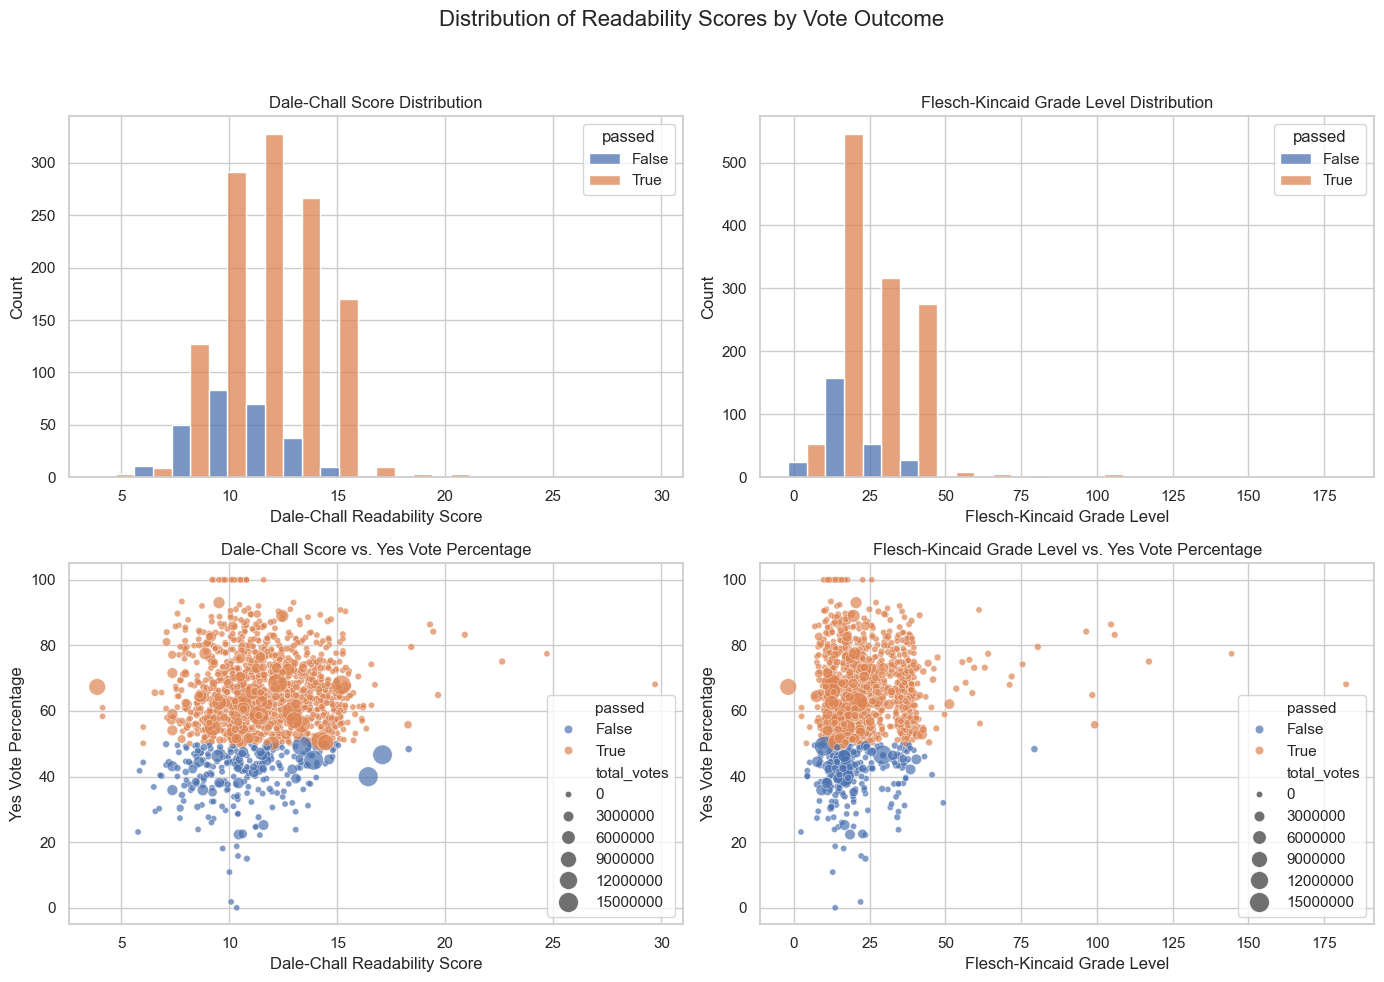

In [114]:
# 2. Create a faceted histogram showing distribution of readability scores by vote outcome
plt.figure(figsize=(14, 10))

# Create a binary outcome variable (passed/failed)
complete_data['passed'] = complete_data.vote_margin > 0

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Readability Scores by Vote Outcome', fontsize=16)

# Dale-Chall score distribution
sns.histplot(
    data=complete_data, 
    x='dale_chall_score', 
    hue='passed',
    multiple='dodge', 
    bins=15,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Dale-Chall Score Distribution')
axes[0, 0].set_xlabel('Dale-Chall Readability Score')
axes[0, 0].set_ylabel('Count')

# Flesch-Kincaid grade level distribution
sns.histplot(
    data=complete_data, 
    x='flesch_kincaid_score', 
    hue='passed',
    multiple='dodge', 
    bins=15,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Flesch-Kincaid Grade Level Distribution')
axes[0, 1].set_xlabel('Flesch-Kincaid Grade Level')
axes[0, 1].set_ylabel('Count')

# Dale-Chall vs. Yes Vote Percentage
sns.scatterplot(
    data=complete_data,
    x='dale_chall_score',
    y=complete_data.yes_count / complete_data.total_votes * 100,
    hue='passed',
    size='total_votes',
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Dale-Chall Score vs. Yes Vote Percentage')
axes[1, 0].set_xlabel('Dale-Chall Readability Score')
axes[1, 0].set_ylabel('Yes Vote Percentage')

# Flesch-Kincaid vs. Yes Vote Percentage
sns.scatterplot(
    data=complete_data,
    x='flesch_kincaid_score',
    y=complete_data.yes_count / complete_data.total_votes * 100,
    hue='passed',
    size='total_votes',
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Flesch-Kincaid Grade Level vs. Yes Vote Percentage')
axes[1, 1].set_xlabel('Flesch-Kincaid Grade Level')
axes[1, 1].set_ylabel('Yes Vote Percentage')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('readability_by_outcome.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

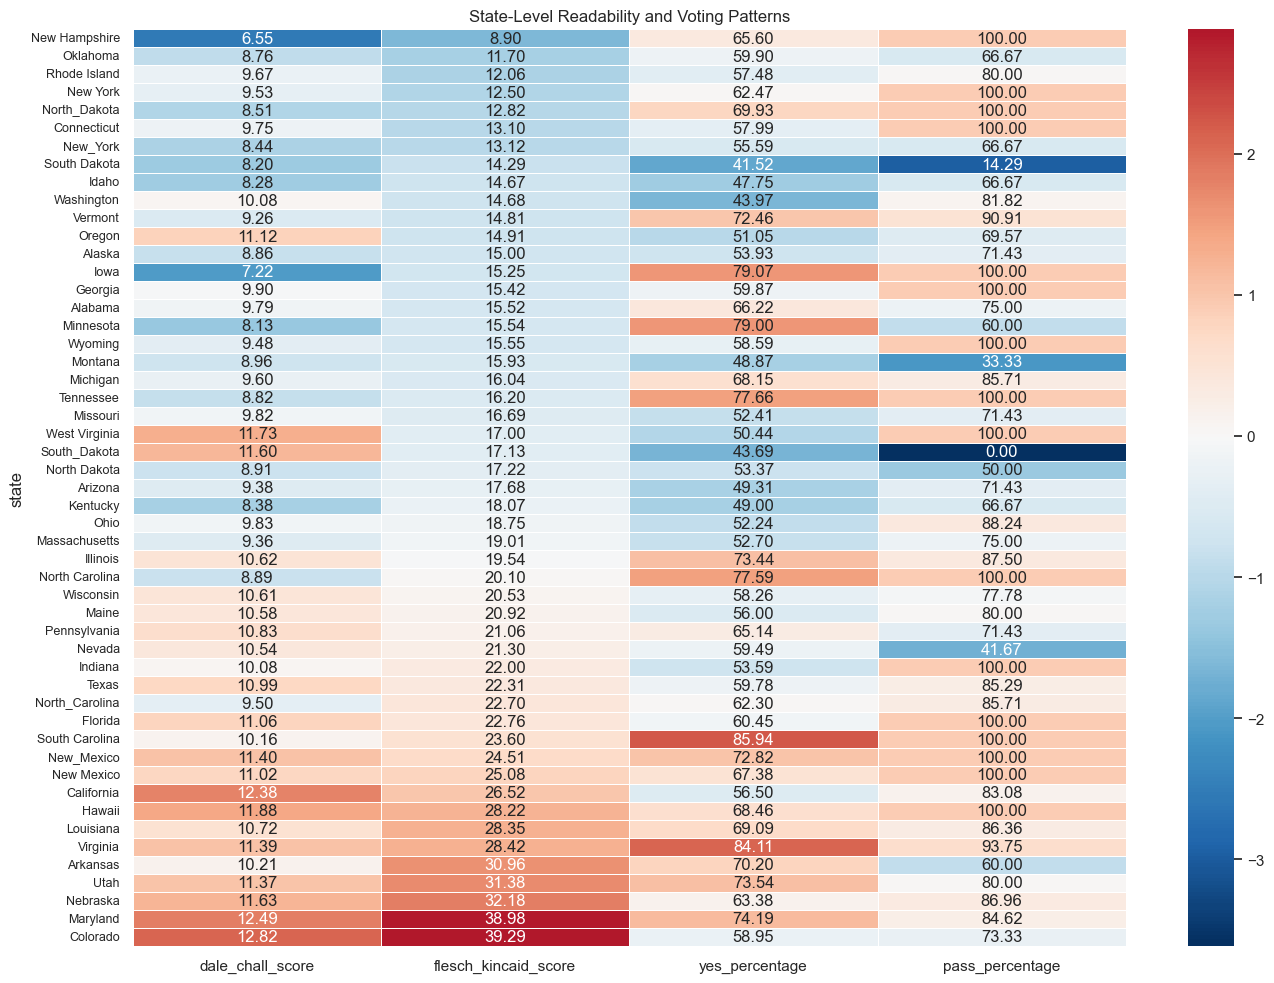

In [116]:
# Fixed state-level heatmap with all state names visible
plt.figure(figsize=(14, 10))

# Sort by Flesch-Kincaid score
state_aggregation = state_aggregation.sort_values('flesch_kincaid_score')

# Create heatmap data
heatmap_data = state_aggregation.set_index('state')[
    ['dale_chall_score', 'flesch_kincaid_score', 'yes_percentage', 'pass_percentage']
]

# Normalize data for better visualization
heatmap_normalized = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()

# Create heatmap with specific y-tick settings
ax = sns.heatmap(
    heatmap_normalized, 
    cmap='RdBu_r', 
    center=0, 
    annot=heatmap_data.round(2),
    fmt='.2f',
    linewidths=.5,
    yticklabels=1  # Force showing all tick labels
)

# Ensure all state names are visible
_ = plt.yticks(rotation=0)  # Keep text horizontal
_ = plt.tick_params(axis='y', which='major', labelsize=9)  # Adjust text size if needed
_ = plt.title('State-Level Readability and Voting Patterns')
_ = plt.tight_layout()
_ = plt.savefig('state_level_heatmap_fixed.png')
_ = plt.show()

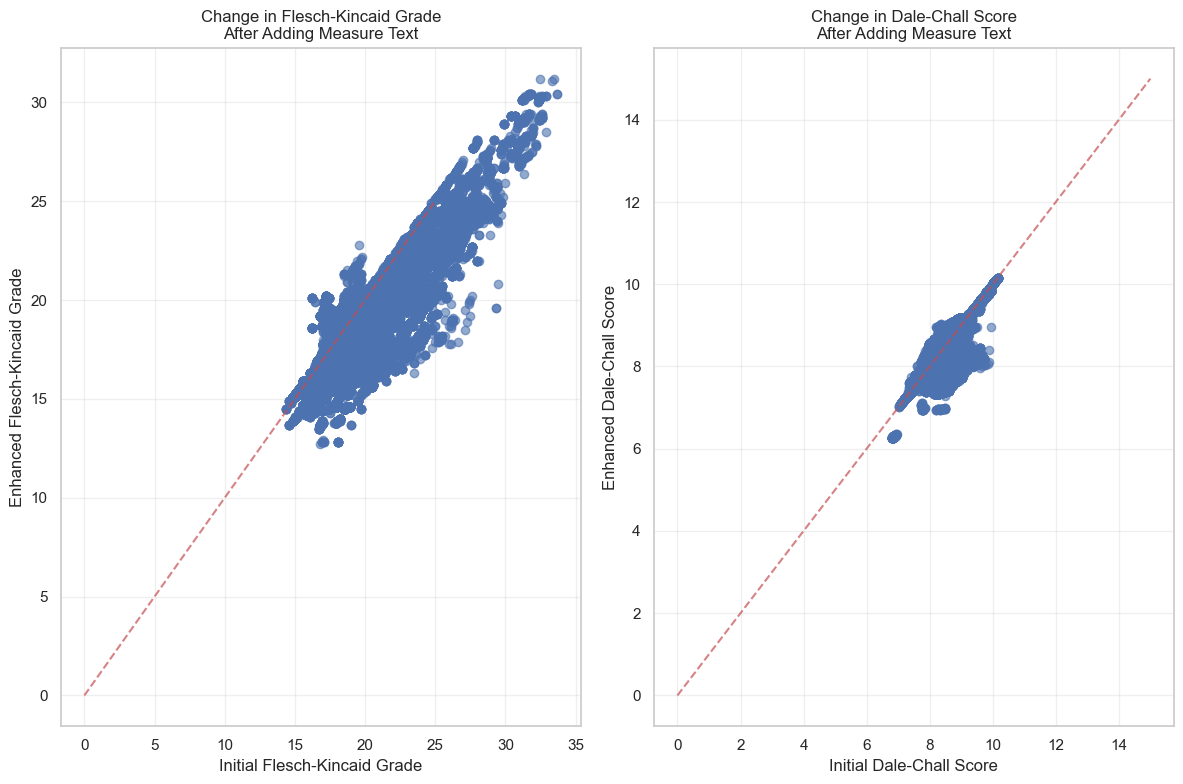

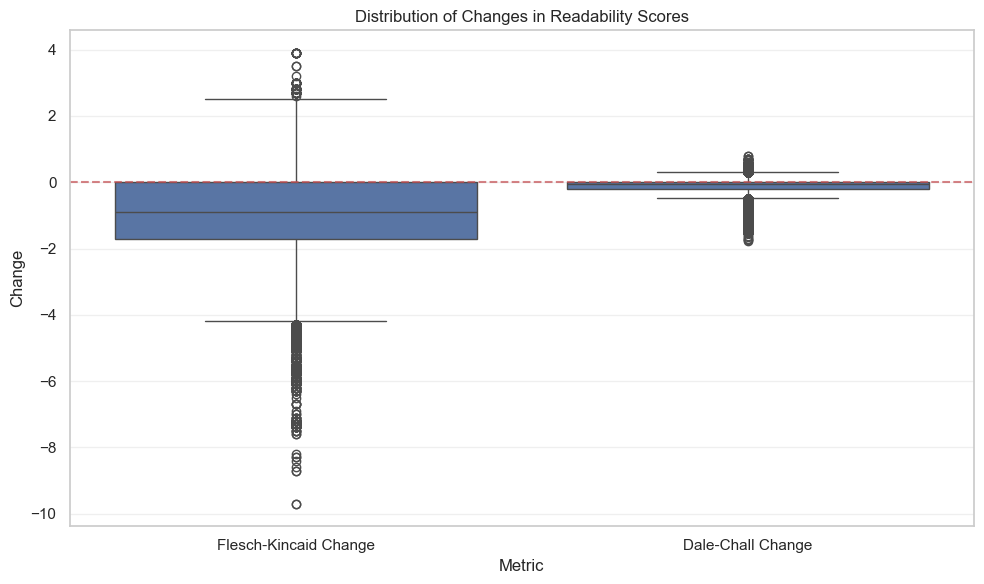

In [117]:
# 4. Visualize readability changes after adding measure text
_ = plt.figure(figsize=(12, 8))
# Create a scatterplot of before vs after readability scores
_ = plt.subplot(1, 2, 1)
_ = plt.scatter(
    ballot_data_df.flesch_kincaid_initial,
    ballot_data_df.flesch_kincaid_enhanced,
    alpha=0.6
)
_ = plt.plot([0, 25], [0, 25], 'r--', alpha=0.7)  # Diagonal line (no change)
_ = plt.xlabel('Initial Flesch-Kincaid Grade')
_ = plt.ylabel('Enhanced Flesch-Kincaid Grade')
_ = plt.title('Change in Flesch-Kincaid Grade\nAfter Adding Measure Text')
_ = plt.grid(True, alpha=0.3)

_ = plt.subplot(1, 2, 2)
_ = plt.scatter(
    ballot_data_df.dale_chall_initial,
    ballot_data_df.dale_chall_enhanced,
    alpha=0.6
)
_ = plt.plot([0, 15], [0, 15], 'r--', alpha=0.7)  # Diagonal line (no change)
_ = plt.xlabel('Initial Dale-Chall Score')
_ = plt.ylabel('Enhanced Dale-Chall Score')
_ = plt.title('Change in Dale-Chall Score\nAfter Adding Measure Text')
_ = plt.grid(True, alpha=0.3)

_ = plt.tight_layout()
_ = plt.savefig('readability_changes.png')
_ = plt.show()

# Create a box plot of changes
_ = plt.figure(figsize=(10, 6))
changes_df = pd.DataFrame({
    'Flesch-Kincaid Change': ballot_data_df.flesch_kincaid_enhanced - ballot_data_df.flesch_kincaid_initial,
    'Dale-Chall Change': ballot_data_df.dale_chall_enhanced - ballot_data_df.dale_chall_initial
})
changes_melted = changes_df.melt(var_name='Metric', value_name='Change')

_ = sns.boxplot(data=changes_melted, x='Metric', y='Change')
_ = plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
_ = plt.title('Distribution of Changes in Readability Scores')
_ = plt.grid(axis='y', alpha=0.3)
_ = plt.tight_layout()
_ = plt.savefig('readability_changes_boxplot.png')
_ = plt.show()

<Figure size 1400x1200 with 0 Axes>

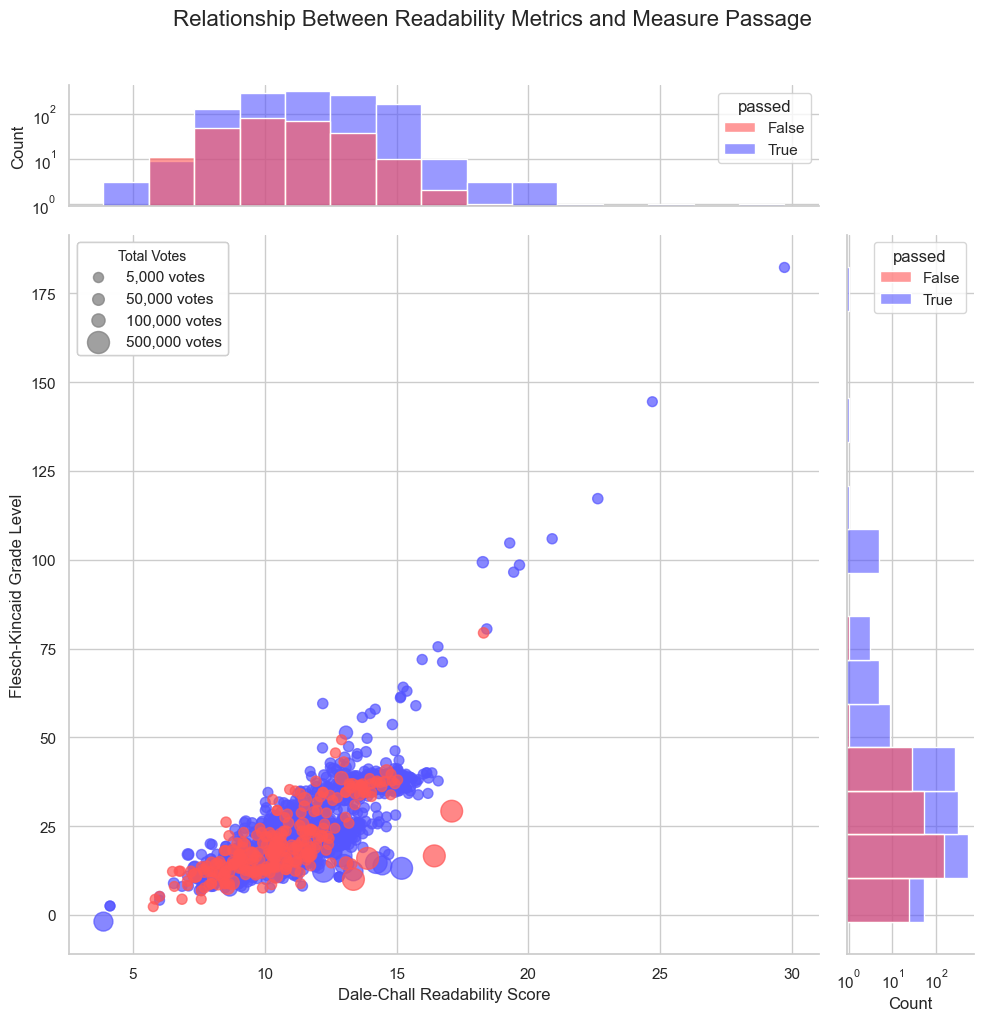

In [119]:
# Fixed joint plot visualization with proper histograms
_ = plt.figure(figsize=(14, 12))

# Calculate Yes vote percentage for coloring
complete_data['yes_percentage'] = complete_data.yes_count / complete_data.total_votes * 100

# Create separate scatterplots for passed and failed measures
g = sns.JointGrid(
    data=complete_data,
    x='dale_chall_score',
    y='flesch_kincaid_score',
    height=10,
    ratio=5,
    marginal_ticks=True
)

# Add scatterplot to joint grid
for passed, color in [(True, '#5555FF'), (False, '#FF5555')]:
    subset = complete_data[complete_data.passed == passed]
    
    # Scale sizes for better visibility
    sizes = 50 + (subset.total_votes / subset.total_votes.max() * 200)
    
    _ = g.ax_joint.scatter(
        subset.dale_chall_score, 
        subset.flesch_kincaid_score,
        s=sizes,
        color=color,
        alpha=0.7,
        label="Passed" if passed else "Failed"
    )

# Add histograms for marginal distributions with element='bars' explicitly set
_ = sns.histplot(
    data=complete_data,
    x='dale_chall_score',
    hue='passed',
    palette=['#FF5555', '#5555FF'],
    alpha=0.6,
    bins=15,
    element='bars',  # Explicitly specify bars
    ax=g.ax_marg_x
)
# Set log scale for counts after creating the histogram
_ = g.ax_marg_x.set_yscale('log')

_ = sns.histplot(
    data=complete_data,
    y='flesch_kincaid_score',
    hue='passed',
    palette=['#FF5555', '#5555FF'],
    alpha=0.6,
    bins=15,
    element='bars',  # Explicitly specify bars
    ax=g.ax_marg_y
)
# Set log scale for counts after creating the histogram
_ = g.ax_marg_y.set_xscale('log')

# Add custom title and labels
_ = g.fig.suptitle('Relationship Between Readability Metrics and Measure Passage', fontsize=16, y=1.02)
_ = g.ax_joint.set_xlabel('Dale-Chall Readability Score', fontsize=12)
_ = g.ax_joint.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)

# Add a legend for the main plot
_ = g.ax_joint.legend(title='Measure Outcome')

# Add a legend for sizes
handles = []
labels = []
for size in [5000, 50000, 100000, 500000]:
    handle = plt.scatter([], [], s=50 + (size/500000*200), color='gray', alpha=0.7)
    handles.append(handle)
    labels.append(f'{size:,} votes')

# Add the size legend
size_legend = g.ax_joint.legend(
    handles, labels,
    title='Total Votes',
    loc='upper left',
    frameon=True,
    framealpha=0.8,
    title_fontsize=10
)

# Add both legends (need to add the first one back after adding the second)
_ = g.ax_joint.add_artist(g.ax_joint.get_legend())
_ = g.ax_joint.add_artist(size_legend)

# Ensure minimum count is 1 for log scale
_ = g.ax_marg_x.set_ylim(bottom=0.9)
_ = g.ax_marg_y.set_xlim(left=0.9)

_ = plt.tight_layout()
_ = plt.savefig('readability_metrics_joint_analysis_log_scale_fixed.png')
_ = plt.show()